In [1]:
%matplotlib inline

from __future__ import division

from qiime.parse import parse_mapping_file
from qiime.format import format_mapping_file
from skbio.io.util import open_file
from biom import load_table
from scipy.stats import mannwhitneyu

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

def load_mf(fn):
    with open_file(fn, 'U') as f:
        mapping_data, header, _ = parse_mapping_file(f)
        _mapping_file = pd.DataFrame(mapping_data, columns=header)
        _mapping_file.set_index('SampleID', inplace=True)
    return _mapping_file

def write_mf(f, _df):
    with open_file(f, 'w') as fp:
        lines = format_mapping_file(['SampleID'] + _df.columns.tolist(),
                                    list(_df.itertuples()))
        fp.write(lines+'\n')

We got the data from Jan's Dropbox, we transferred that data and processed in barnacle using the following commands:

```bash
# verify the mapping file looks fine
validate_mapping_file.py \
-m 09512JS530F-mapping2.txt \
-o validated-mapping-file

# demux the sequences
split_libraries.py \
-f sequences/09512JS530F-full.fasta.gz \
-m demuxing-mapping-file.txt \
-q sequences/09512JS530F-full.qual.gz \
-o sequences/split-libraries/ \
-b 8

pick_closed_reference_otus.py \
-i /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/sequences/split-libraries/seqs.fna \
-o /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/otus/uclust -a -O 32

# we have more samples than what we should be using so filter those out
awk -F'\t' '{ if( NR > 1) {print $1} }' mapping-file.txt > samples-to-keep.txt
filter_samples_from_otu_table.py \
-i /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/otus/uclust/otu_table.biom \
-o /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/otus/uclust/otu_table.filtered.biom \
--sample_id_fp /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/samples-to-keep.txt

# beta diversity at 4500 and 5000
beta_diversity_through_plots.py \
-i /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/otus/uclust/otu_table.filtered.biom \
-o /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/beta/4500 \
-m /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/mapping-file.txt \
-a -O 10 \
-t /home/yovazquezbaeza/research/gg_13_8_otus/trees/97_otus.tree \
-e 4500

beta_diversity_through_plots.py \
-i /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/otus/uclust/otu_table.filtered.biom \
-o /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/beta/5000 \
-m /home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/mapping-file.txt \
-a -O 10 \
-t /home/yovazquezbaeza/research/gg_13_8_otus/trees/97_otus.tree \
-e 5000
```

For simplicity, we have only downloaded the `otus` and `beta` folders.

# Download the data form barnacle

In [33]:
mkdir -p minamoto

In [34]:
!scp -r barnacle:/home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/otus minamoto/ > /dev/null

/home/yovazquezbaeza/.bashrc: line 34: module: command not found
discarding /home/yovazquezbaeza/miniconda/bin from PATH
prepending /home/yovazquezbaeza/miniconda/envs/qiime/bin to PATH


In [35]:
!scp -r barnacle:/home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/beta minamoto/ > /dev/null
!scp -r barnacle:/home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/mapping-file.txt minamoto/ > /dev/null

/home/yovazquezbaeza/.bashrc: line 34: module: command not found
discarding /home/yovazquezbaeza/miniconda/bin from PATH
prepending /home/yovazquezbaeza/miniconda/envs/qiime/bin to PATH
/home/yovazquezbaeza/.bashrc: line 34: module: command not found
discarding /home/yovazquezbaeza/miniconda/bin from PATH
prepending /home/yovazquezbaeza/miniconda/envs/qiime/bin to PATH


In [27]:
!scp -r barnacle:/home/yovazquezbaeza/research/suchodolski-dogs/extra-samples/mapping-file.alpha.txt minamoto/ > /dev/null

/home/yovazquezbaeza/.bashrc: line 34: module: command not found
discarding /home/yovazquezbaeza/miniconda/bin from PATH
prepending /home/yovazquezbaeza/miniconda/envs/qiime/bin to PATH


In [10]:
ls minamoto/

beta/             mapping-file.txt  otus/


Generate taxonomic summaries so we can calculate the dysbiosis index.

In [20]:
!wc -l minamoto/mapping-file.alpha.txt

      34 minamoto/mapping-file.alpha.txt


In [28]:
!summarize_taxa.py \
-i minamoto/beta/4500/otu_table.filtered_even4500.biom \
-m minamoto/mapping-file.alpha.txt \
-o minamoto/taxa-summaries/4500

In [2]:
md = {}

md['good'] = ['k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Slackia',
'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides',
'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella',
'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__[Prevotella]',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Butyricicoccus',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Megamonas',
'k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Allobaculum',
'k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Catenibacterium',
'k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__[Eubacterium]',
'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium',
'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Sutterella']

md['bad'] = ['k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus',
'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__',
'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Granulicatella',
'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus',
'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus',
'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Mogibacteriaceae];g__',
'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__',
'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Serratia',
'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas',
'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiohalorhabdales;f__;g__']

Calculate the dysbiosis index with the list of bacteria above.

In [3]:
mf = load_mf('minamoto/taxa-summaries/4500/mapping-file.alpha_L6.txt')

mf['PD_whole_tree_even_4500_alpha'] = pd.to_numeric(mf.PD_whole_tree_even_4500_alpha, errors='coerce')

prot = set(md['good'])
infl = set(md['bad'])

mf['Protective'] = pd.Series(np.zeros_like(mf.index.values), mf.index, dtype=np.float)
mf['Inflammatory'] = pd.Series(np.zeros_like(mf.index.values), mf.index, dtype=np.float)

for column_name in mf.columns:
    if any([True for p in prot if p in column_name]):
        mf['Protective'] += mf[column_name].astype(np.float)
    elif any([True for i in infl if i in column_name]):
        mf['Inflammatory'] += mf[column_name].astype(np.float)
    else:
        continue

# calculating the dysbiosis index

mf['Protective'].replace(0, np.nan, inplace=True)
mf['Dogbyosis Index'] = np.divide(mf['Inflammatory'], mf['Protective']).astype(np.float)

# drop any samples with undefined values
mf['Dogbyosis Index'].replace({0: np.nan}, inplace=True)
mf['Dogbyosis Index'] = np.log(mf['Dogbyosis Index'])

Note that the sample sizes are very small in this dataset.

# Samples from dogs with IBD before antibiotic treatment

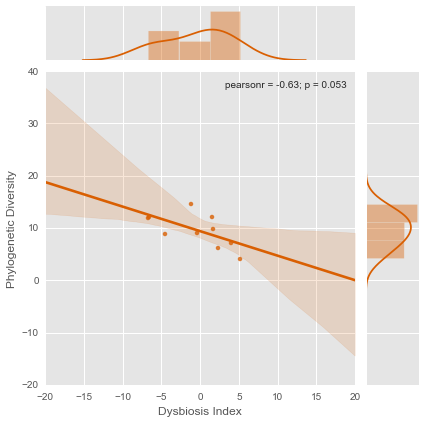

In [14]:
sns.jointplot(x='Dogbyosis Index', y='PD_whole_tree_even_4500_alpha', data=mf[mf.AB == 'No'],
              kind='reg', color='#d95f02')
sns.axlabel('Dysbiosis Index', 'Phylogenetic Diversity')
plt.savefig('minamoto/ibd-no-abxs.pdf')

# Samples from dogs with IBD after antibiotic treatment

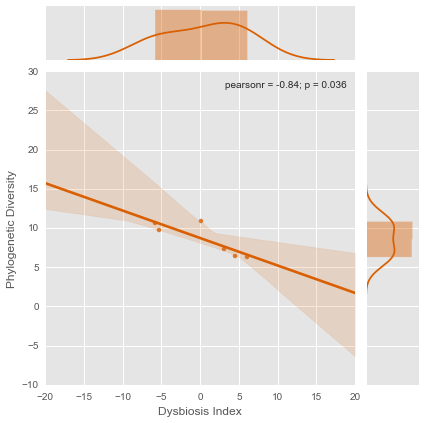

In [15]:
sns.jointplot(x='Dogbyosis Index', y='PD_whole_tree_even_4500_alpha', data=mf[mf.AB == 'Yes'], kind='reg',
              color='#d95f02')
sns.axlabel('Dysbiosis Index', 'Phylogenetic Diversity')
plt.savefig('minamoto/ibd-yes-abxs.pdf')

# Samples from non-IBD dogs.

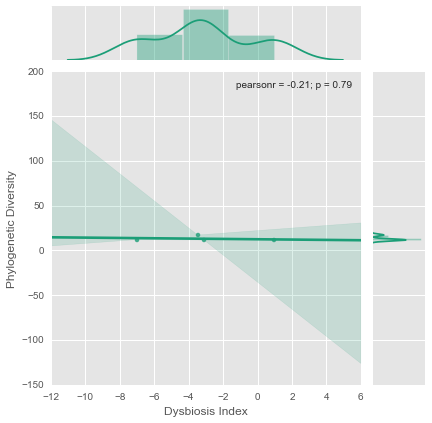

In [16]:
sns.jointplot(x='Dogbyosis Index', y='PD_whole_tree_even_4500_alpha', data=mf[mf.AB == 'No_HEALTHY'], kind='reg',
              color='#1b9e77')
sns.axlabel('Dysbiosis Index', 'Phylogenetic Diversity')
plt.savefig('minamoto/non-ibd.pdf')